# ex11-Reclassify DEM

A very useful technique to work with raster data (such as ***DEM***) is changing their values or grouping them into categories, which is the so-called ***reclassificatioin***. In another word, ***reclassification*** is the process of reassigning a value, a range of values, or a list of values in a raster to new output values. There are several reasons to classify rasters:

- set specific values to NoData to exclude them from analysis;
- change values in response to new information or classification schemes;
- replace one set of values with an associated set;
- assign values of preference, priority, sensitivity, or similar criteria to a raster;
- others.

There are two categories of classifying methods (Joel Lawhead, 2019). The first one is fairly simple, which is based only on some value distribution algorithm derived from the histogram of raster data or user-defined groups. This kind of simplest methods is called ***unsupervised*** classifications, where no additional input is given other than the image itself. The second category is quite complicated as it may involve training datasets and even computer learning and artificial intelligence. Generally, this kind of methods involves some sort of training data to guide the computer. Therefore it is called ***supervised*** classifications. For example, identifying crop types from satellite images is a kind of typical application of supervised classification.

Here we will only touch the unsupervised classification method, where values for each cell are compared with the range limits in the lookup table, considering the specified comparison criteria. Whenever a value falls into a given range, the class value specified for this range will be used in the output layer. The following image presents an example of how to reclassify the original values from base raster by ranges to new reclassified values:


![reclassify](img/reclassificatioin.gif)*Example of reclassification by value ranges (Image source: ESRI.)*

## Raster Classification Steps

From the above demo image, we know that the raster [processing workflow](https://www.earthdatascience.org/courses/earth-analytics-python/lidar-raster-data/classify-plot-raster-data-in-python/) could be broken into several steps as follows:

- ***Step 1: Data import / cleanup***
Load and “clean” the data. This may include cropping, dealing with NA values, etc.

- ***Step 2: Data exploration***
Understand the range and distribution of values in your data. This may involve plotting histograms scatter plots, etc.

- ***Step 3: More data processing & analysis***
This may include the final data processing steps that you determined based upon the data exploration phase.

- ***Step 4: Final data analysis***
The final steps of your analysis - often performed using information gathered in the early data processing / exploration stages of your workflow.

- ***Step 5: Presentation***
Refining your results into a final plot or set of plots that are cleaned up, labeled, etc.

Keep in mind that these steps are not compulsory, which depends on your data. You always can figure out your won workflow. For example, sometimes the Step 2 and 3 could be not necessary if you already know the specified classification criteria in advance. 

## Python implement

Although many geosptial software such as ArcMap and QGIS provides raster reclassification functions, in fact, using Python to reclassfy rasters is also quite convenient. And sometimes, you could figure out more customized classification criteria to fit your purpose than those software.

The ***Step 1, 2, 3 and 5*** have presented in previous tutorials. 
- We always apply xarray (backended with rasterio) to read and clean data.
- We use scipy.stats and seaborn to explore data and check data distributions (bins). Or we could use the numpy.histogram() to compute the histogram of a set of data, easily.

- We use matplotlib (+ cartopy) to visualize and present final results.

Look, you already mastered most of the steps and only ***Step 4*** is left. Let's have a look how to convert cell values to categories. Firstly, let's presume that the DEM data is stored in a 2D numpy.array with rows and columns (actually they are).  

The ***first method*** is that you can use an ***iteration*** precedure to pick each cell along with rows and column to compare with each category bounds and assign a new value to that cell. This is the most straightforward method and quite easy to implement. However, it is always not a good idea to use loops in Python. 

Luckily, we have the ***second choice*** that ***numpy*** has a function called ***digitize( )*** that could simplify our classifying task. ***numpy.digitize( )*** is similar to how histogram works, because it categorizes datapoints into bins. However, unlike histogram, it doesn’t aggregate/count the number of values within each bin. Instead, digitize will replace each datapoint with an integer corresponding to which bin it belongs to (i.e., category). You can use this to determine which datapoints fall within certain ranges. 

*I strongly suggest you to have a look at [this tutorial](https://www.earthdatascience.org/courses/earth-analytics-python/lidar-raster-data/classify-plot-raster-data-in-python/), which presented a procedure step by step to create a classified canopy height model (CHM). Moreover, many material is extracted from the tutorial and therefore all credit also should go to it.*

However, it is not my style to operate on numpy.array since we already applied ***xarray*** to read and clean data. It should be better to work directly on xarray.dataarray, instead of convert it to numpy.array (unless no other choises). ***We have the third method :).*** We can use the python package of [mapclassify](https://pysal.org/mapclassify/api.html) to reclassify rasters, which could be done by ***xarray.apply_ufunc(mapclassify.method)***.

mapclassify is an open-source python library for Choropleth map classification and includes quite a few unsupervised classification methods as follows:
- Box_Plot
- EqualInterval
- FisherJenks
- FisherJenksSampled
- HeadTailBreaks
- JenksCaspall
- JenksCaspallForced
- JenksCaspallSampled
- MaxP
- MaximumBreaks
- NaturalBreaks
- Quantiles
- Percentiles
- StdMean
- UserDefined.

In this notebook, we will firstly present a simple reclassification example based on mapclassify. After this, you will find it is not that difficult to reproduce [the tutorial of reclassifying CHM mentioned above](https://www.earthdatascience.org/courses/earth-analytics-python/lidar-raster-data/classify-plot-raster-data-in-python/) based on mapclassify. Leave it to you to explore.

## Show time

In [1]:
%matplotlib inline

import numpy as np
import xarray as xr
import mapclassify as mc
import matplotlib.pyplot as plt

from functools import partial
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, BoundaryNorm

import warnings
warnings.filterwarnings("ignore")

#### Read and preprocess DEM data

Removing with nodata values

In [2]:
infile = "data/FloodFill/terrain.asc"

da_dem = xr.open_rasterio(infile).drop('band')[0].rename({'x':'longitude', 'y':'latitude'})
nodata = da_dem.nodatavals[0]
da_dem = da_dem.where(da_dem>nodata, np.nan)

#### Reclassify DEM using Quantiles

Map Raster Values to New Values

In [3]:
da_dem_stack = da_dem.stack(point=['latitude', 'longitude'])
da_dem_class = xr.apply_ufunc(mc.Quantiles.make(rolling=True), da_dem_stack).unstack('point')

#### Comparison visualization

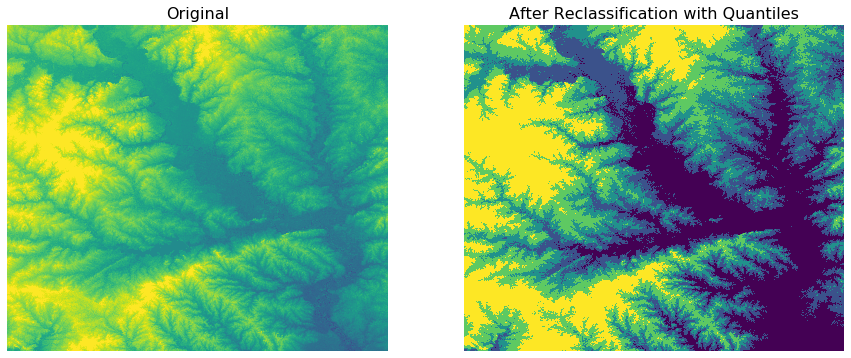

In [4]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))

da_dem.plot(ax=ax[0], vmax=150, vmin=0, add_colorbar=False)
ax[0].axis('off')
_= ax[0].set_title('Original', fontsize=16)

da_dem_class.plot(ax=ax[1],  add_colorbar=False )
ax[1].axis('off')
_= ax[1].set_title('After Reclassification with Quantiles', fontsize=16)

## Bonus

*Steps to reproduce the tutorial of reclassifying CHM mentioned above*

- Read and clean data
- Create the CHM (See [Sup2: DEM, DTM, DSM and Canopy Height Model](https://lnkd.in/gpWfM-Q))
- Self-define category bounds (bins)
- Classify the data
- Visualization

Most of these steps are quite easy to achieve. But you may meet a little bit difficult at  *xarray.apply_ufunc(mapclassify.method, da_chm)*. If you can figure out an elegant solution, instead of using hard-code, I can confirm that you actually move a big step towards applying xarray to analyze spatial data.

The final reclassification image I reproduced looks almost the same to the original tutorial.![reclasschm](img/reclassifyingCHM.png)

#### Read and clean data

In [5]:
dtm_path = 'data/colorado-flood/spatial/boulder-leehill-rd/pre-flood/lidar/pre_DTM.tif'
dsm_path = 'data/colorado-flood/spatial/boulder-leehill-rd/pre-flood/lidar/pre_DSM.tif'

da_dtm = xr.open_rasterio(dtm_path).drop('band')[0].rename({'x':'longitude', 'y':'latitude'})
nodata = da_dtm.nodatavals[0]
da_dtm = da_dtm.where(da_dtm>nodata, np.nan)

da_dsm = xr.open_rasterio(dsm_path).drop('band')[0].rename({'x':'longitude', 'y':'latitude'})
nodata = da_dsm.nodatavals[0]
da_dsm = da_dsm.where(da_dsm>nodata, np.nan)

#### Create CHM

In [6]:
lidar_chm_im = da_dsm - da_dtm

#### Define bins and classify chm

In [7]:
# Define bins that you want, and then classify the data
class_bins = [lidar_chm_im.min(), 2, 7, 12, np.inf]

#clsfunc = partial(mc.UserDefined, bins=class_bins)
lidar_chm_im_stack = lidar_chm_im.stack(point=['latitude', 'longitude'])

# filling this part
# wrap classify funtion feasible for xarray.apply_ufunc
p_func = partial(mc.User_Defined.make(bins=class_bins))

# You'll classify the original image array, then unravel it again for plotting
lidar_chm_im_class = xr.apply_ufunc(p_func, 
                                    lidar_chm_im_stack,                                    
                                   ).unstack('point')

# post-process
lidar_chm_class_ma = lidar_chm_im_class.where(lidar_chm_im_class != 0, np.nan)

#### Visualization

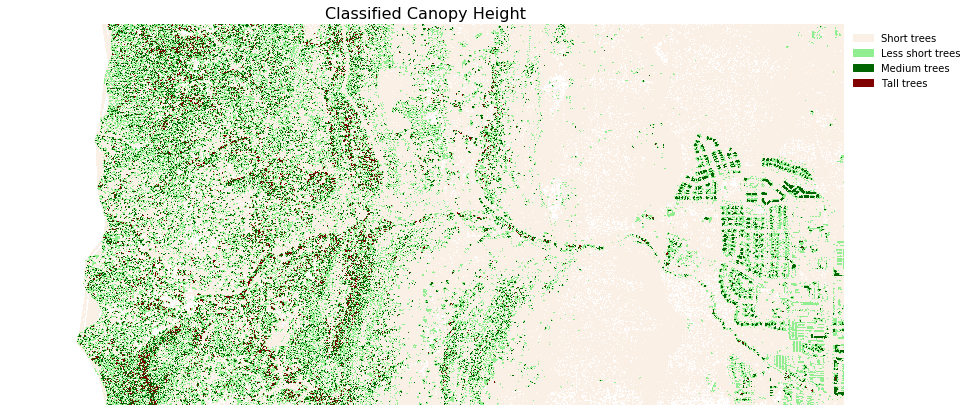

In [8]:
# Plot data using nicer colors
colors = ['linen', 'lightgreen', 'darkgreen', 'maroon']

cmap = ListedColormap(colors)
norm = BoundaryNorm(class_bins, len(colors))

# Create a list of labels to use for your legend
height_class_labels = ["Short trees", "Less short trees", "Medium trees", "Tall trees"]

# A path is an object drawn by matplotlib. In this case a patch is a box draw on your legend
# Below you create a unique path or box with a unique color - one for each of the labels above
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(colors, height_class_labels)]

fig, ax = plt.subplots(figsize=(15, 7))
lidar_chm_class_ma.plot(ax=ax, cmap=cmap, add_colorbar=False)

ax.legend(handles=legend_patches,
          facecolor="white",
          edgecolor="white",
          bbox_to_anchor=(1.15, 1))  # Place legend to the RIGHT of the map
ax.set_axis_off()
_= ax.set_title("Classified Canopy Height", fontsize=16)

## References

Joel Lawhead (2019). Learning Geospatial Analysis with Python - Third Edition.

Travis E, Oliphant. A guide to NumPy, USA: Trelgol Publishing, (2006).

Stéfan van der Walt, S. Chris Colbert and Gaël Varoquaux. The NumPy Array: A Structure for Efficient Numerical Computation, Computing in Science & Engineering, 13, 22-30 (2011), DOI:10.1109/MCSE.2011.37

Fernando Pérez and Brian E. Granger. IPython: A System for Interactive Scientific Computing, Computing in Science & Engineering, 9, 21-29 (2007), DOI:10.1109/MCSE.2007.53

John D. Hunter. Matplotlib: A 2D Graphics Environment, Computing in Science & Engineering, 9, 90-95 (2007), DOI:10.1109/MCSE.2007.55

https://rasterio.readthedocs.io/en/stable/

http://xarray.pydata.org/en/stable/

https://github.com/pysal/mapclassify

https://www.earthdatascience.org/courses/earth-analytics/lidar-raster-data-r/classify-raster/